# Movie Review Sentiment Analysis 

### Importing laibraries

In [2]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth',400)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from bs4 import BeautifulSoup
import re,string,unicodedata
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from keras import backend as K
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.preprocessing.text import Tokenizer
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification , AutoTokenizer
from keras.utils import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU,  BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, ZeroPadding1D, Add, Flatten, Dot, Concatenate, Lambda
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D, TimeDistributed, Attention
from keras.layers import InputSpec, Layer
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

## EDA

In [7]:
# Selecting a subset of data to be faster in demonstration
train_df = pd.read_csv('Train.csv',encoding="utf-8")
valid_df = pd.read_csv('Valid.csv',encoding="utf-8")
test_df = pd.read_csv('Test.csv',encoding="utf-8")
sub = pd.read_csv('sample_submission.csv')

train_df.head(10)

Train: 40000
Valid: 5000
Test: 5000


,text,label
0,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The onl...",0.0
1,"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some...",0.0
2,Why do people who do not know what a particular time in the past was like feel the need to try to define that time for others? Replace Woodstock with the Civil War and the Apollo moon-landing with the Titanic sinking and you've got as realistic a flick as this formulaic soap opera populated entirely by low-life trash. Is this what kids who were too young to be allowed to go to Woodstock and wh...,0.0
3,"Even though I have great interest in Biblical movies, I was bored to death every minute of the movie. Everything is bad. The movie is too long, the acting is most of the time a Joke and the script is horrible. I did not get the point in mixing the story about Abraham and Noah together. So if you value your time and sanity stay away from this horror.",0.0
4,"Im a die hard Dads Army fan and nothing will ever change that. I got all the tapes, DVD's and audiobooks and every time i watch/listen to them its brand new. <br /><br />The film. The film is a re run of certain episodes, Man and the hour, Enemy within the gates, Battle School and numerous others with a different edge. Introduction of a new General instead of Captain Square was a brilliant mov...",1.0
5,"A terrible movie as everyone has said. What made me laugh was the cameo appearance by Scott McNealy, giving an award to one of the murdered programmers in front of a wall of SUN logos. McNealy is the CEO of SUN Microsystem, a company that practically defines itself by its hatred of Microsoft. They have been instrumental in filing antitrust complaints against Microsoft. So, were they silly enou...",0.0
6,"Finally watched this shocking movie last night, and what a disturbing mindf**ker it is, and unbelievably bloody and some unforgettable scenes, and a total assault on the senses. Looks like a movie from the minds of Lynch (specifically ERASERHEAD), Buttgereit, and even a little of ""Begotten"". What this guy does to his pregnant sister is beyond belief, but then again, did it really happen or is ...",1.0
7,"I caught this film on AZN on cable. It sounded like it would be a good film, a Japanese ""Green Card"". I can't say I've ever disliked an Asian film, quite the contrary. Some of the most incredible horror films of all time are Japanese and Korean, and I am a HUGE fan of John Woo's Hong Kong films. I an not adverse to a light hearted films, like Tampopo or Chung King Express (two of my favourites...",0.0
8,"It may be the remake of 1987 Autumn's Tale after eleven years, as the director Mabel Cheung claimed. Mabel employs rock music as the medium in this movie to express her personal attitude to life, in which love, desire and the consequential frustration play significantly crucial roles. Rock music may not be the best vehicle to convey the profound sentiment, and yet it is not too inappropriate t...",1.0
9,"My Super Ex Girlfriend turned out to be a pleasant surprise for me, I was really expecting a horrible movie that would probably be stupid and predictable, and you know what? It was! But this movie did have so many wonderful laughs and a fun plot that anyone could get a kick out of. I know that this was a very cheesy movie, but Uma and Anna were just so co

In [ ]:
print('Train: '+ str(len(train_df)))
print('Valid: '+ str(len(valid_df)))
print('Test: '+ str(len(test_df)))
train_df["label"] = train_df.label.astype(float)

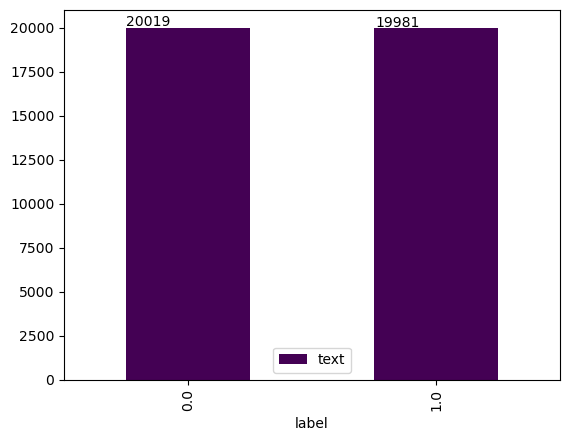

In [8]:
ax = train_df.groupby('label').count().plot(kind='bar', colormap='viridis')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


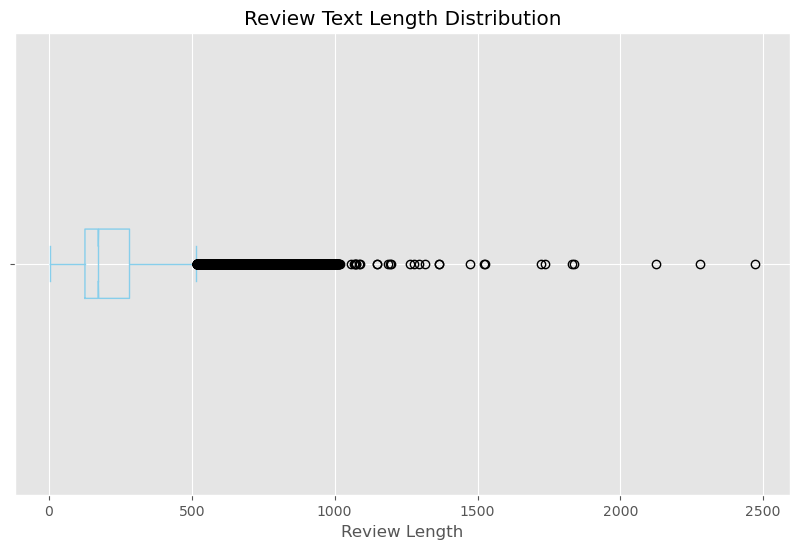

In [12]:
# Calculate review lengths
review_len = pd.Series([len(review.split()) for review in train_df['text']])

plt.style.use('ggplot')
plt.figure(figsize=(10, 6))

ax = review_len.plot(kind='box', color='skyblue', notch=True, vert=False, whis=1.5)
ax.set_title('Review Text Length Distribution')
ax.set_xlabel('Review Length')

plt.show()



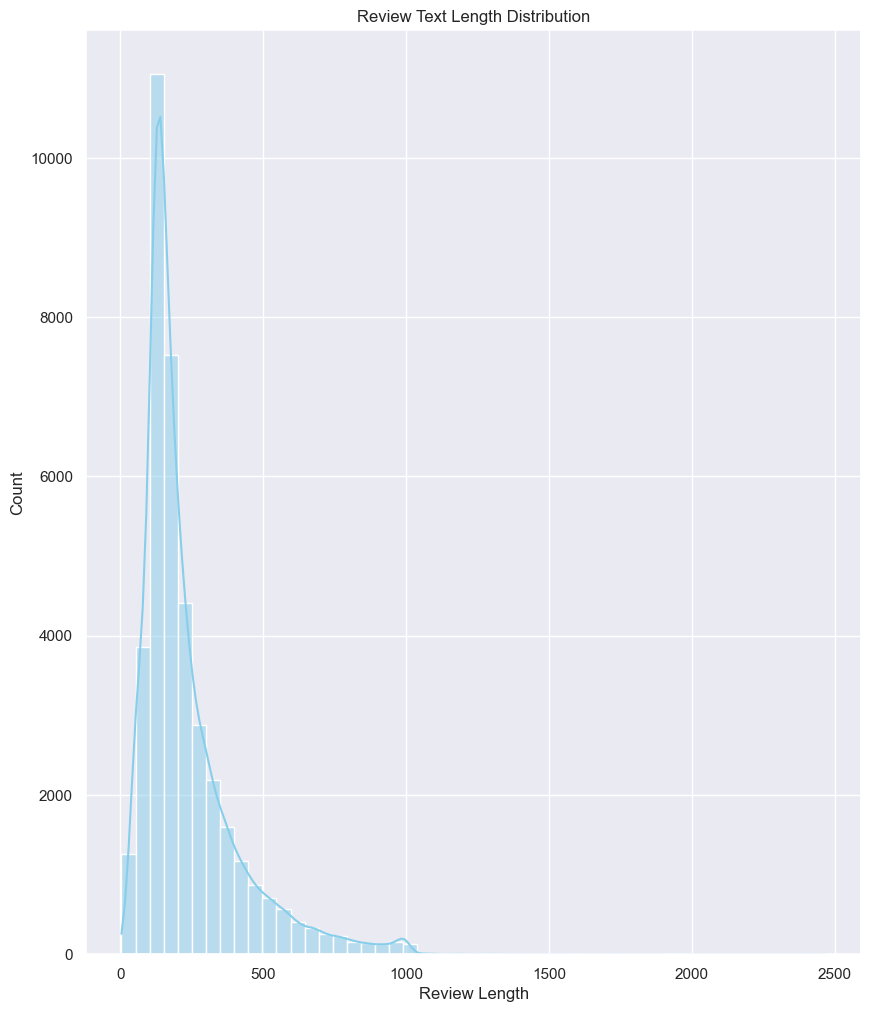

In [13]:
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None,
)

plt.figure(figsize = (10,12))

ax = sns.histplot(review_len, color='skyblue', bins=50, kde=True)
ax.set_title('Review Text Length Distribution')
ax.set_xlabel('Review Length')
ax.set_ylabel('Count')

plt.show()


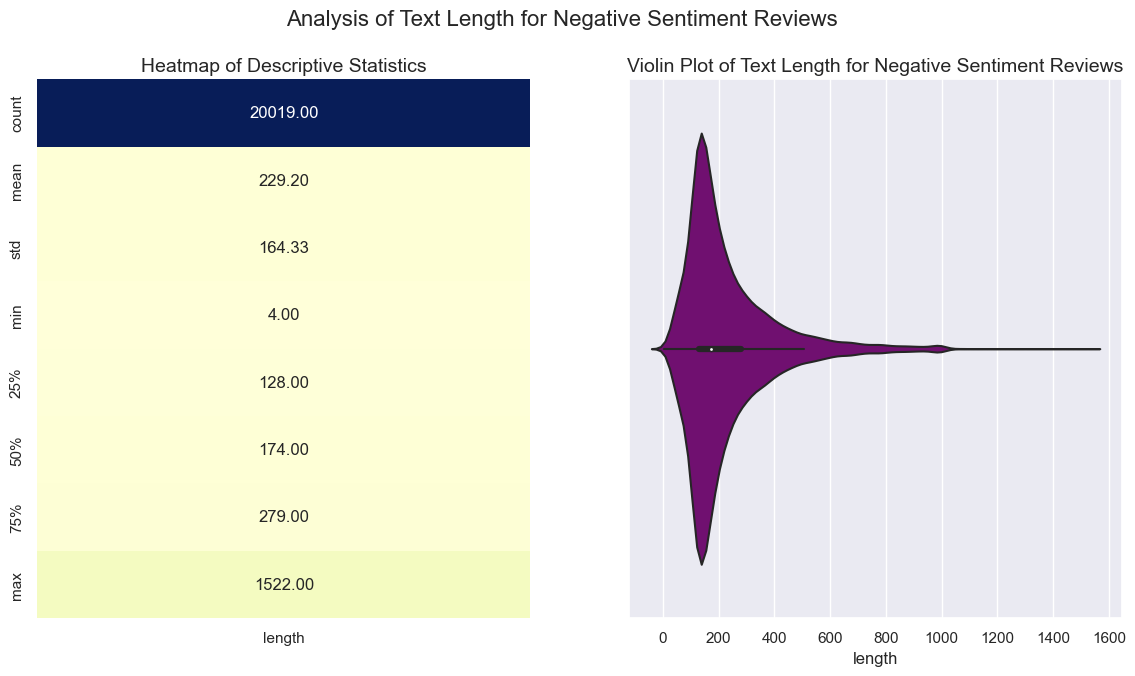

In [22]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.violinplot(x=train_df[train_df['label']==0]['length'], ax=ax1, color='purple')
ax1.set_title('Violin Plot of Text Length for Negative Sentiment Reviews', fontsize=14)
describe = train_df.length[train_df.label==0].describe().to_frame().round(2)
ax2 = fig.add_subplot(121)
sns.heatmap(describe, annot=True, fmt=".2f", cmap='YlGnBu', cbar=False, ax=ax2)
ax2.set_title('Heatmap of Descriptive Statistics', fontsize=14)
fig.suptitle('Analysis of Text Length for Negative Sentiment Reviews', fontsize=16)

plt.show()

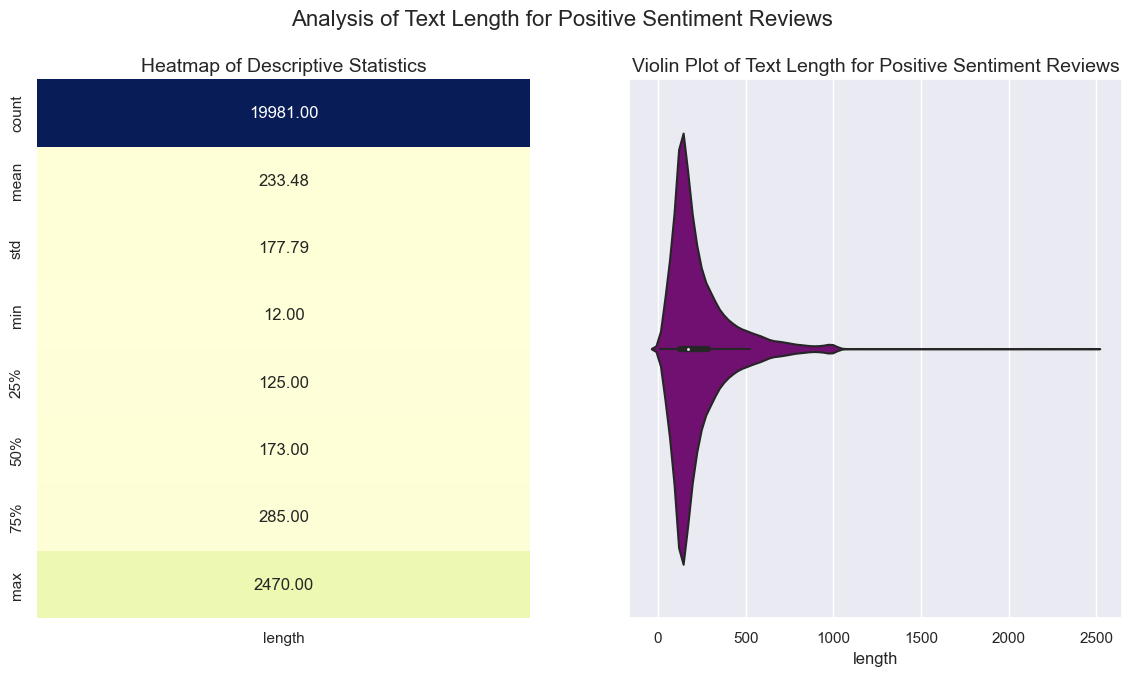

In [23]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.violinplot(x=train_df[train_df['label']==1]['length'], ax=ax1, color='purple')
ax1.set_title('Violin Plot of Text Length for Positive Sentiment Reviews', fontsize=14)
describe = train_df.length[train_df.label==1].describe().to_frame().round(2)
ax2 = fig.add_subplot(121)
sns.heatmap(describe, annot=True, fmt=".2f", cmap='YlGnBu', cbar=False, ax=ax2)
ax2.set_title('Heatmap of Descriptive Statistics', fontsize=14)
fig.suptitle('Analysis of Text Length for Positive Sentiment Reviews', fontsize=16)

plt.show()

###  Negative review (Label: 0)

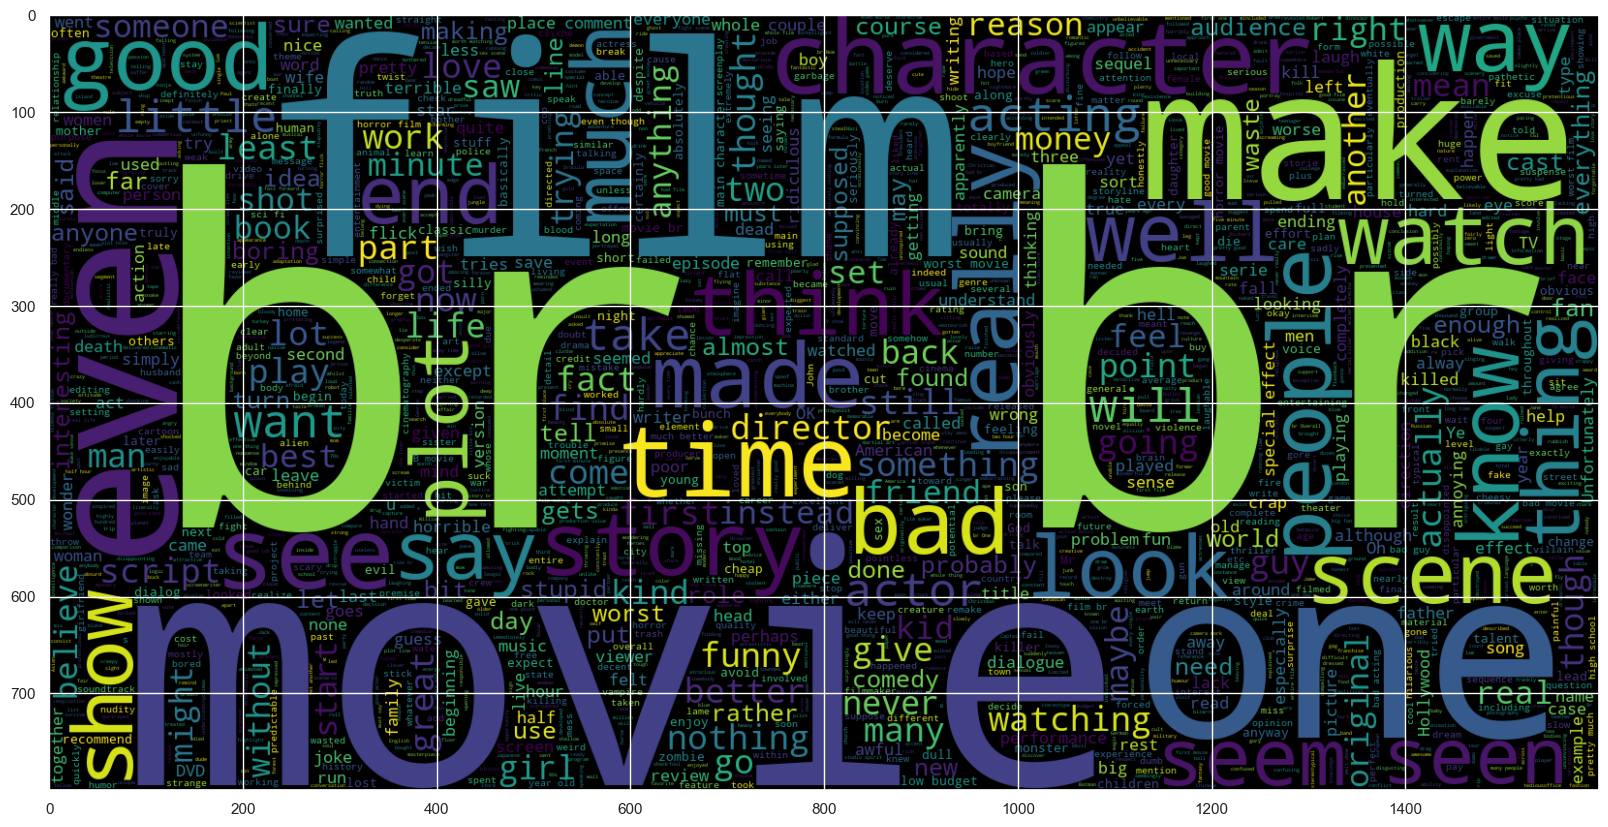

In [27]:
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(train_df[train_df.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

### Positive review (Label: 1)


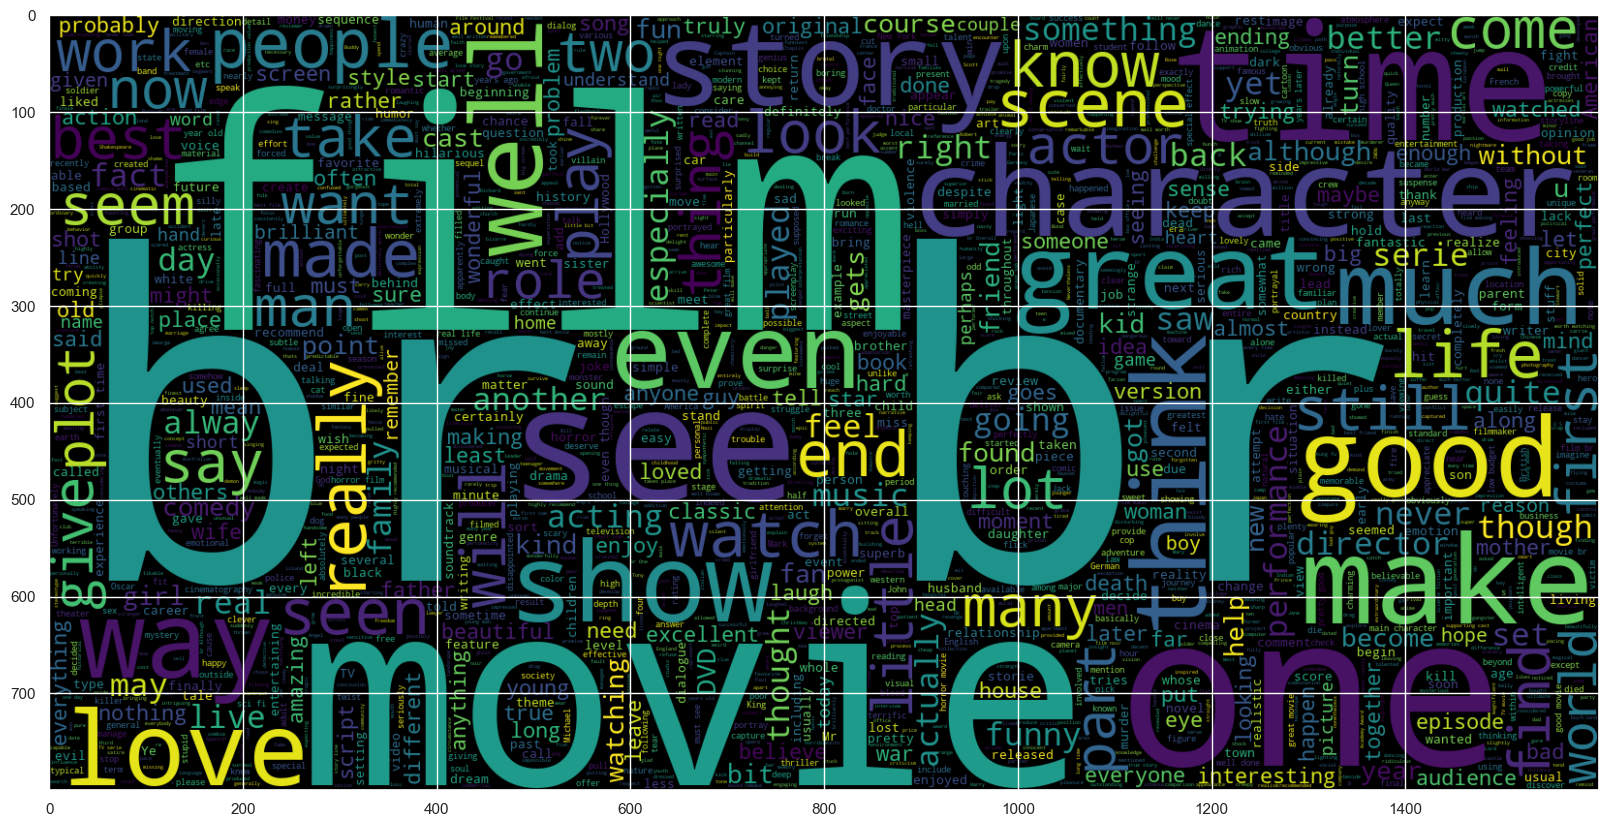

In [28]:
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(train_df[train_df.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

---
## Text Preprocessing steps
1. **Cleaning**: This step involves removing unnecessary characters like punctuation, special characters, numbers, and common words (also known as stop words) such as "the," "a," "and," etc.

2. **Lowercasing**: In this step, all the words are converted to lowercase. This is done to ensure that different cases of the same word are treated as the same. For example, "good" and "Good" are treated as the same word.

3. **Tokenization**: This is the process of splitting the text into individual words or phrases, which are known as tokens.

4. **Stemming/Lemmatization**: This step simplifies words to their base or root form. Stemming involves removing the suffixes from words, while lemmatization involves reducing words to their base form based on their part of speech.



6. **Sentiment Score**: In this step, a sentiment score is assigned to each token based on a sentiment lexicon (a dictionary of words and their sentiment polarity).

7. **Feature Encoding**: This step involves converting text data into numerical representations that machine learning algorithms can understand. This can be done using various techniques such as one-hot encoding, TF-IDF, or word embedding.



In [10]:
# Turning all text to lowercase
train_df['text'] = train_df['text'].str.lower()
valid_df['text'] = valid_df['text'].str.lower()
test_df['text'] = test_df['text'].str.lower()
train_df.head()

,text,label,length
0,"i grew up (b. 1965) watching and loving the thunderbirds. all my mates at school watched. we played ""thunderbirds"" before school, during lunch and after school. we all wanted to be virgil or scott. no one wanted to be alan. counting down from 5 became an art form. i took my children to see the movie hoping they would get a glimpse of what i loved as a child. how bitterly disappointing. the onl...",0.0,151
1,"when i put this movie in my dvd player, and sat down with a coke and some chips, i had some expectations. i was hoping that this movie would contain some of the strong-points of the first movie: awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. but, to my disappointment, not any of this is to be found in atlantis: milo's return. had i read some...",0.0,326
2,why do people who do not know what a particular time in the past was like feel the need to try to define that time for others? replace woodstock with the civil war and the apollo moon-landing with the titanic sinking and you've got as realistic a flick as this formulaic soap opera populated entirely by low-life trash. is this what kids who were too young to be allowed to go to woodstock and wh...,0.0,184
3,"even though i have great interest in biblical movies, i was bored to death every minute of the movie. everything is bad. the movie is too long, the acting is most of the time a joke and the script is horrible. i did not get the point in mixing the story about abraham and noah together. so if you value your time and sanity stay away from this horror.",0.0,69
4,"im a die hard dads army fan and nothing will ever change that. i got all the tapes, dvd's and audiobooks and every time i watch/listen to them its brand new. <br /><br />the film. the film is a re run of certain episodes, man and the hour, enemy within the gates, battle school and numerous others with a different edge. introduction of a new general instead of captain square was a brilliant mov...",1.0,178


In [11]:
# Removing punctuation
exclude = set(string.punctuation)

def remove_punctuation(x):
    try:
        x = ''.join(ch for ch in x if ch not in exclude)
    except:
        pass
    return x

train_df['text'] = train_df['text'].apply(remove_punctuation)
valid_df['text'] = valid_df['text'].apply(remove_punctuation)
test_df['text'] = test_df['text'].apply(remove_punctuation)
train_df.head()

,text,label,length
0,i grew up b 1965 watching and loving the thunderbirds all my mates at school watched we played thunderbirds before school during lunch and after school we all wanted to be virgil or scott no one wanted to be alan counting down from 5 became an art form i took my children to see the movie hoping they would get a glimpse of what i loved as a child how bitterly disappointing the only high point w...,0.0,151
1,when i put this movie in my dvd player and sat down with a coke and some chips i had some expectations i was hoping that this movie would contain some of the strongpoints of the first movie awsome animation good flowing story excellent voice cast funny comedy and a kickass soundtrack but to my disappointment not any of this is to be found in atlantis milos return had i read some reviews first ...,0.0,326
2,why do people who do not know what a particular time in the past was like feel the need to try to define that time for others replace woodstock with the civil war and the apollo moonlanding with the titanic sinking and youve got as realistic a flick as this formulaic soap opera populated entirely by lowlife trash is this what kids who were too young to be allowed to go to woodstock and who fai...,0.0,184
3,even though i have great interest in biblical movies i was bored to death every minute of the movie everything is bad the movie is too long the acting is most of the time a joke and the script is horrible i did not get the point in mixing the story about abraham and noah together so if you value your time and sanity stay away from this horror,0.0,69
4,im a die hard dads army fan and nothing will ever change that i got all the tapes dvds and audiobooks and every time i watchlisten to them its brand new br br the film the film is a re run of certain episodes man and the hour enemy within the gates battle school and numerous others with a different edge introduction of a new general instead of captain square was a brilliant move especially wh...,1.0,178


In [12]:
# Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
# Apply function on review column
train_df['text'] = train_df['text'].apply(denoise_text)
valid_df['text'] = valid_df['text'].apply(denoise_text)
test_df['text'] = test_df['text'].apply(denoise_text)
train_df.head()

,text,label,length
0,i grew up b 1965 watching and loving the thunderbirds all my mates at school watched we played thunderbirds before school during lunch and after school we all wanted to be virgil or scott no one wanted to be alan counting down from 5 became an art form i took my children to see the movie hoping they would get a glimpse of what i loved as a child how bitterly disappointing the only high point w...,0.0,151
1,when i put this movie in my dvd player and sat down with a coke and some chips i had some expectations i was hoping that this movie would contain some of the strongpoints of the first movie awsome animation good flowing story excellent voice cast funny comedy and a kickass soundtrack but to my disappointment not any of this is to be found in atlantis milos return had i read some reviews first ...,0.0,326
2,why do people who do not know what a particular time in the past was like feel the need to try to define that time for others replace woodstock with the civil war and the apollo moonlanding with the titanic sinking and youve got as realistic a flick as this formulaic soap opera populated entirely by lowlife trash is this what kids who were too young to be allowed to go to woodstock and who fai...,0.0,184
3,even though i have great interest in biblical movies i was bored to death every minute of the movie everything is bad the movie is too long the acting is most of the time a joke and the script is horrible i did not get the point in mixing the story about abraham and noah together so if you value your time and sanity stay away from this horror,0.0,69
4,im a die hard dads army fan and nothing will ever change that i got all the tapes dvds and audiobooks and every time i watchlisten to them its brand new br br the film the film is a re run of certain episodes man and the hour enemy within the gates battle school and numerous others with a different edge introduction of a new general instead of captain square was a brilliant move especially wh...,1.0,178


In [13]:
import nltk
nltk.download('stopwords')
# set stopwords to english
stop=set(stopwords.words('english'))
stopword_list=nltk.corpus.stopwords.words('english')
print(stop)

# Create an instance of the TweetTokenizer class
# Tokenization of text
tokenizer=TweetTokenizer()


# removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
#Apply function on review column
stop = stopwords.words('english')

train_df['text'] = train_df['text'].apply(remove_stopwords)
valid_df['text'] = valid_df['text'].apply(remove_stopwords)
test_df['text'] = test_df['text'].apply(remove_stopwords)
train_df.head()

[nltk_data] Downloading package stopwords to C:\Users\Tonjoring Pro
[nltk_data]     V.2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'s', 'our', 'couldn', 'we', "hasn't", 'each', 'out', 'wouldn', "you've", 'be', 'but', 'won', 'or', 'hadn', 'yours', 'into', 'own', "mightn't", 'such', 'am', 'them', 'there', 'how', 'nor', 'who', 'had', 'yourselves', 'few', 'weren', 'at', "she's", 'above', 'when', "you'd", 'why', 'will', 'against', "couldn't", 're', 'same', "shouldn't", 'hasn', 'ours', 'its', 'doing', 'off', "isn't", 'she', 'as', 'so', "doesn't", 'are', 'y', 'themselves', 'whom', 'from', 'being', 'do', 'shan', 'which', 'then', "that'll", 'these', 'those', 'has', 'me', 'should', 'if', "needn't", "wouldn't", 'an', 'until', 'between', 'with', 'o', 'didn', 'm', 'her', 'very', 'before', 'ma', 'herself', "didn't", "you're", "it's", 'were', 'having', 'your', 'all', 'some', 'don', "should've", 'haven', 'both', 'up', "wasn't", 've', "aren't", "hadn't", 'doesn', 'only', 'i', 'and', 'under', 'because', 'his', 'him', 'during', 'did', 'here', 'myself', 'what', 'he', 'while', 'ourselves', 'now', 'below', 'than', "haven't", "you'll",

,text,label,length
0,grew b 1965 watching loving thunderbirds mates school watched played thunderbirds school lunch school wanted virgil scott one wanted alan counting 5 became art form took children see movie hoping would get glimpse loved child bitterly disappointing high point snappy theme tune could compare original score thunderbirds thankfully early saturday mornings one television channel still plays reruns...,0.0,151
1,put movie dvd player sat coke chips expectations hoping movie would contain strongpoints first movie awsome animation good flowing story excellent voice cast funny comedy kickass soundtrack disappointment found atlantis milos return read reviews first might let following paragraph directed seen first movie enjoyed primarily points mentionedbr br first scene appears shock picked atlantis milos ...,0.0,326
2,people know particular time past like feel need try define time others replace woodstock civil war apollo moonlanding titanic sinking youve got realistic flick formulaic soap opera populated entirely lowlife trash kids young allowed go woodstock failed grade school composition ill show old meanies ill put movie prove dont know nuttin topic still make money yeah already know one thing watching ...,0.0,184
3,even though great interest biblical movies bored death every minute movie everything bad movie long acting time joke script horrible get point mixing story abraham noah together value time sanity stay away horror,0.0,69
4,im die hard dads army fan nothing ever change got tapes dvds audiobooks every time watchlisten brand new br br film film run certain episodes man hour enemy within gates battle school numerous others different edge introduction new general instead captain square brilliant move especially wouldnt cash cheque something rarely done nowbr br follows early years getting equipment uniforms starting ...,1.0,178


In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
dataset['text'] = dataset['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


In [14]:
# Create an instance of the TfidfVectorizer class with n-grams of size 1 and 2,
# and use the TweetTokenizer to tokenize the text
vectorizer = TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1, 2), tokenizer=tokenizer.tokenize)
# Combine the text from the train and test dataframes into a list
full_text = list(train_df['text'].values) + list(test_df['text'].values)
# Fit the vectorizer on the combined text
vectorizer.fit(full_text)
# Use the fitted vectorizer to transform the text in the train, test and validation dataframe into a sparse matrix of TF-IDF values
train_vectorized = vectorizer.transform(train_df['text'])
test_vectorized = vectorizer.transform(test_df['text'])
valid_vectors = vectorizer.transform(valid_df['text'])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [15]:
y = train_df['label']

In [21]:
tk = Tokenizer(lower = True, filters='')
tk.fit_on_texts(full_text)

In [22]:
train_tokenized = tk.texts_to_sequences(train_df['text'])
test_tokenized = tk.texts_to_sequences(test_df['text'])

In [23]:
max_len = 100
X_train = pad_sequences(train_tokenized, maxlen = max_len)
X_test = pad_sequences(test_tokenized, maxlen = max_len)

In [24]:
'''from google.colab import drive
drive.mount('/content/drive')
with open('/content/drive/My Drive/crawl-300d-2M.vec', 'r') as f:
    print(f.read())'''


"from google.colab import drive\ndrive.mount('/content/drive')\nwith open('/content/drive/My Drive/crawl-300d-2M.vec', 'r') as f:\n    print(f.read())"

In [53]:
# Define the path to the pre-trained word embedding file
embedding_path = "crawl-300d-2M.vec"
# Set the size of the word embeddings to 300
embed_size = 300
# Set the maximum number of features to 30,000
max_features = 169449

In [54]:
# This function returns a tuple with the word and its corresponding coefficients as a numpy array
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
# Load the pre-trained embeddings file and create a dictionary of word vectors
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path, encoding='utf-8'))

# Get the index of each word in the tokenizer
word_index = tk.word_index
# Set the number of words to be used as the minimum between the maximum features allowed and the number of words in the tokenizer
nb_words = min(max_features, len(word_index))
# Initialize an embedding matrix of zeros with shape (nb_words + 1, embed_size)
embedding_matrix = np.zeros((nb_words + 1, embed_size))
# Iterate over each word in the tokenizer and its index
for word, i in word_index.items():
    # If the index of the word is greater than or equal to the maximum features allowed, skip it
    if i >= max_features: continue
    # Get the embedding vector of the word from the pre-trained embeddings dictionary
    embedding_vector = embedding_index.get(word)
    # If the embedding vector is not None, add it to the embedding matrix at the index of the word in the tokenizer
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

### Using OneHotEncoder

In [55]:
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(y.values.reshape(-1, 1))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Model 1: GRU + CONV + LSTM

In [60]:
def build_model1(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    file_path = "best_model_2.h5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(169449, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x1)
    max_pool1_gru = GlobalMaxPooling1D()(x1)

    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool3_gru = GlobalAveragePooling1D()(x3)
    max_pool3_gru = GlobalMaxPooling1D()(x3)

    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x1)
    max_pool1_lstm = GlobalMaxPooling1D()(x1)

    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x3)
    max_pool3_lstm = GlobalMaxPooling1D()(x3)

    

    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
                    

    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy",
                  optimizer = Adam(lr = lr, weight_decay = lr_d),
                  metrics = ["accuracy"])
    history = model.fit(X_train, y_ohe, batch_size = 128, epochs = 30, validation_split=0.1,
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

In [61]:
model1 = build_model1(
    33learning_rate = 1e-3,
                      lr_d = 1e-10,
                      units = 64,
                      spatial_dr = 0.3,
                      kernel_size1=3,
                      kernel_size2=2,
                      dense_units=32,
                      dr=0.2,
                      conv_size=64)

Epoch 1/30
282/282 [==============================] - ETA: 0s - loss: 0.4386 - accuracy: 0.8049
Epoch 1: val_loss improved from inf to 0.32872, saving model to best_model_2.h5


C:\Users\Tonjoring Pro V.2\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


282/282 [==============================] - 133s 438ms/step - loss: 0.4386 - accuracy: 0.8049 - val_loss: 0.3287 - val_accuracy: 0.8637
Epoch 2/30
282/282 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.8609
Epoch 2: val_loss improved from 0.32872 to 0.30094, saving model to best_model_2.h5
282/282 [==============================] - 111s 392ms/step - loss: 0.3335 - accuracy: 0.8609 - val_loss: 0.3009 - val_accuracy: 0.8783
Epoch 3/30
282/282 [==============================] - ETA: 0s - loss: 0.3090 - accuracy: 0.8715
Epoch 3: val_loss did not improve from 0.30094
282/282 [==============================] - 111s 395ms/step - loss: 0.3090 - accuracy: 0.8715 - val_loss: 0.3181 - val_accuracy: 0.8675
Epoch 4/30
282/282 [==============================] - ETA: 0s - loss: 0.2895 - accuracy: 0.8801
Epoch 4: val_loss improved from 0.30094 to 0.28672, saving model to best_model_2.h5
282/282 [==============================] - 112s 397ms/step - loss: 0.2895 - accuracy: 0.8801

###  GRU + CONV + LSTM + ATTENTION

In [68]:
def build_model2(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    file_path = "best_model_3.h5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
    
    inp = Input(shape = (max_len,))
    x = Embedding(169449, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)

    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x_conv1)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)

    x_conv2 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool2_gru = GlobalAveragePooling1D()(x_conv2)
    max_pool2_gru = GlobalMaxPooling1D()(x_conv2)


    x_conv3 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x_conv3)
    max_pool1_lstm = GlobalMaxPooling1D()(x_conv3)

    x_conv4 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool2_lstm = GlobalAveragePooling1D()(x_conv4)
    max_pool2_lstm = GlobalMaxPooling1D()(x_conv4)

    x_conv5 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x_conv5)
    max_pool3_lstm = GlobalMaxPooling1D()(x_conv5)

    # Attention Mechanism
    attention_gru = Attention(max_len)([x_gru, x_gru])
    attention_lstm = Attention(max_len)([x_lstm, x_lstm])

    # Flatten layers for attention layers
    attention_gru = Flatten()(attention_gru)
    attention_lstm = Flatten()(attention_lstm)

    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool2_gru, max_pool2_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool2_lstm, max_pool2_lstm,
                    avg_pool2_lstm, max_pool3_lstm, attention_gru, attention_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy",
                  optimizer = Adam(lr = lr, weight_decay = lr_d),
                  metrics = ["accuracy"])
    history = model.fit(X_train, y_ohe, batch_size = 128, epochs = 20, validation_split=0.1,
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

In [70]:
model2 = build_model2(lr = 1e-3,
                      lr_d = 1e-5,
                      units = 64,
                      spatial_dr = 0.5,
                      kernel_size1=3,
                      kernel_size2=3,
                      dense_units=64,
                      dr=0.3,
                      conv_size=64)

Epoch 1/20
282/282 [==============================] - ETA: 0s - loss: 0.4740 - accuracy: 0.7829
Epoch 1: val_loss improved from inf to 0.34421, saving model to best_model_3.h5
282/282 [==============================] - 505s 2s/step - loss: 0.4740 - accuracy: 0.7829 - val_loss: 0.3442 - val_accuracy: 0.8593
Epoch 2/20
282/282 [==============================] - ETA: 0s - loss: 0.3636 - accuracy: 0.8440
Epoch 2: val_loss improved from 0.34421 to 0.32628, saving model to best_model_3.h5
282/282 [==============================] - 410s 1s/step - loss: 0.3636 - accuracy: 0.8440 - val_loss: 0.3263 - val_accuracy: 0.8600
Epoch 3/20
282/282 [==============================] - ETA: 0s - loss: 0.3411 - accuracy: 0.8553
Epoch 3: val_loss improved from 0.32628 to 0.30719, saving model to best_model_3.h5
282/282 [==============================] - 417s 1s/step - loss: 0.3411 - accuracy: 0.8553 - val_loss: 0.3072 - val_accuracy: 0.8763
Epoch 4/20
282/282 [==============================] - ETA: 0s - loss

In [71]:
model3 = build_model2(lr = 1e-3,
                      lr_d = 1e-7,
                      units = 64,
                      spatial_dr = 0.3,
                      kernel_size1=3,
                      kernel_size2=3,
                      dense_units=64,
                      dr=0.4,
                      conv_size=64)

Epoch 1/20
282/282 [==============================] - ETA: 0s - loss: 0.4467 - accuracy: 0.8070
Epoch 1: val_loss improved from inf to 0.35884, saving model to best_model_3.h5
282/282 [==============================] - 479s 2s/step - loss: 0.4467 - accuracy: 0.8070 - val_loss: 0.3588 - val_accuracy: 0.8555
Epoch 2/20
282/282 [==============================] - ETA: 0s - loss: 0.3450 - accuracy: 0.8578
Epoch 2: val_loss improved from 0.35884 to 0.30190, saving model to best_model_3.h5
282/282 [==============================] - 446s 2s/step - loss: 0.3450 - accuracy: 0.8578 - val_loss: 0.3019 - val_accuracy: 0.8748
Epoch 3/20
282/282 [==============================] - ETA: 0s - loss: 0.3149 - accuracy: 0.8727
Epoch 3: val_loss improved from 0.30190 to 0.28649, saving model to best_model_3.h5
282/282 [==============================] - 448s 2s/step - loss: 0.3149 - accuracy: 0.8727 - val_loss: 0.2865 - val_accuracy: 0.8785
Epoch 4/20
282/282 [==============================] - ETA: 0s - loss

### GRU + LSTM + ATTENTION

In [72]:
def build_model3(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    file_path = "best_model_5.h5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(169449, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)

    # Pad the shorter tensor with zeros along the time axis
    x_gru = ZeroPadding1D(padding=(2, 0))(x_gru)
    x_lstm = ZeroPadding1D(padding=(0, 2))(x_lstm)

    e1 = TimeDistributed(Dense(units*2, activation='tanh'))(x_gru)
    e2 = TimeDistributed(Dense(units*2, activation='tanh'))(x_lstm)
    e = Concatenate()([e1, e2])
    score = Dense(1)(e)
    attention_weights = Activation('softmax')(score)
    context_vector = Dot(axes=1)([attention_weights, x_gru])
    x = concatenate([context_vector, x_lstm], axis=1)

    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x)
    avg_pool1 = GlobalAveragePooling1D()(x1)
    max_pool1 = GlobalMaxPooling1D()(x1)

    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x)
    avg_pool3 = GlobalAveragePooling1D()(x3)
    max_pool3 = GlobalMaxPooling1D()(x3)

    x = concatenate([avg_pool1, max_pool1, avg_pool3, max_pool3])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy",
                  optimizer = Adam(lr = lr, weight_decay = lr_d),
                  metrics = ["accuracy"])
    history = model.fit(X_train, y_ohe, batch_size = 128, epochs = 20, validation_split=0.1,
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

In [73]:
model4 = build_model3(learning_rate = 1e-4,
                      lr_d = 1e-7,
                      units = 128,
                      spatial_dr = 0.5,
                      kernel_size1=4,
                      kernel_size2=3,
                      dense_units=32,
                      dr=0.2,
                      conv_size=64)

Epoch 1/20
282/282 [==============================] - ETA: 0s - loss: 0.4883 - accuracy: 0.7768
Epoch 1: val_loss improved from inf to 0.34826, saving model to best_model_5.h5
282/282 [==============================] - 846s 3s/step - loss: 0.4883 - accuracy: 0.7768 - val_loss: 0.3483 - val_accuracy: 0.8595
Epoch 2/20
282/282 [==============================] - ETA: 0s - loss: 0.3724 - accuracy: 0.8420
Epoch 2: val_loss improved from 0.34826 to 0.31520, saving model to best_model_5.h5
282/282 [==============================] - 640s 2s/step - loss: 0.3724 - accuracy: 0.8420 - val_loss: 0.3152 - val_accuracy: 0.8605
Epoch 3/20
282/282 [==============================] - ETA: 0s - loss: 0.3362 - accuracy: 0.8587
Epoch 3: val_loss improved from 0.31520 to 0.30314, saving model to best_model_5.h5
282/282 [==============================] - 647s 2s/step - loss: 0.3362 - accuracy: 0.8587 - val_loss: 0.3031 - val_accuracy: 0.8710
Epoch 4/20
282/282 [==============================] - ETA: 0s - loss

In [76]:
pred1 = model1.predict(X_test, batch_size = 1024, verbose = 1)
pred = pred1
pred2 = model2.predict(X_test, batch_size = 1024, verbose = 1)
pred += pred2
pred3 = model3.predict(X_test, batch_size = 1024, verbose = 1)
pred += pred3
pred4 = model4.predict(X_test, batch_size = 1024, verbose = 1)
pred += pred4

5/5 [==============================] - 14s 3s/step


In [77]:
predictions = np.round(np.argmax(pred, axis=1)).astype(int)
sub['label'] = predictions
sub.to_csv("Submission_14.csv", index=False)